## Part 1: Notes for graders (^_^) :
### Summary
* 1(a) The generative mixture model for each row is defined by the code in the 3rd cell. In words, the data is generated by sampling from a **Multivariate-Normal (100-d)** distribution. 

* 1(b) The **means** are independent and follow **Nornmal** distributions; the independent **sigmas** follow a **InverseGamma** distribution.

* 1(c) The trace plots could be found below. With sample size = 500, It's hard to tell from the plot because it contains $13*100$ lines. If we focus on individual line, it looks like **the convergency is not good**. One possible way to help the model to converge is to **enlarge the sample size**. If we use a sample size=5000, the convergency would be better **(from my classmates' feedback)**. **From my point of view, I think** to reduce the dimension will also help. Because a lower-dimension means the model can sampling from 'smaller' space thus it's easier to converge to a point. To do this, I plotted the histgram of all 100-dimentions. Then **I evalue each dimension by the standard-deviation**. I filter out the dimensions with smaller sigma, b/c that means they can offer less infomation for clustering. Finally, only 20-dimensions are then selected. (**A threshold is set here, and it's specific value are determined by the elbow's law. See the following $100*100$ plot in which the selected 20 dimensions are highlighten in orange color**). I applied **homogeneity_score , completeness_score and v_measure_score** to evalate the clustter results. You can see from the following cells that after reducing the dimension form 100 to 20, we can get better metric scores. (from [0.531, 0.321, 0.400] to [0.538, 0.517, 0.528])

* 2 As mentioned above, I applied **homogeneity_score , completeness_score and v_measure_score** three metrics to evalate the clustter results. The activation of applying these two metrics is that: 
 - **homogeneity_score** is to tell if one cluster contain only data points which are members of a single true class.
 - **completeness_score** is to evaluate if all members of a given class are assigned to the same cluster.
 - **V-measure** is a harmonic mean of the above two metrics. 
 - **These three metrics** are all independent of the absolute values of the labels, which I think is suitable in this probelm.

  The scores for two clustering results for **healthy.csv and patients.csv** is [0.427, 0.3466, 0.382]. These three scores are pretty **low**, which **indicates the patterns of sub-nodes in these two groups are different with each other**. Thus the clustering results are not close.

* 3 After applying the **Power-Atlas** data as ground trut, I compute the metrics for **healthy v.s. truth** and **patients v.s. truth**:
 - **healthy v.s. truth:** **[homogeneity_score , completeness_score , v_measure_score] = [0.539, 0.517, 0.528]**
 - **patients v.s. truth:** **[homogeneity_score , completeness_score , v_measure_score] = [0.501, 0.390, 0.438]**
 - insights: b/c the truth label is from the healthy human data, thus the healthy.csv data has better scores compared with the patients.csv data.
* 4 
  - All the intermediate results are plotted in the following code cells.
  - If going deeper, I'd like to compare the performance of Bayesian Gaussian Mixed Model with other density- or distance- clustering models.



## Part 2: codes

In [59]:
import pandas as pd
from sklearn.datasets import load_iris
import seaborn as sns
from scipy import stats
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize

In [2]:
healthy = pd.read_csv('healthy.csv', header=None)
df = healthy.values[:,1:]
df.shape

(264, 100)

In [3]:
k = 13  # number of clusters

d = df.shape[1]
n = df.shape[0]

pi = ed.models.Dirichlet(tf.ones(k))
mu = ed.models.Normal(tf.zeros(d), tf.ones(d), sample_shape=k)  # shape (3, 4) 3 gaussians, 4 variates
sigmasq = ed.models.InverseGamma(tf.ones(d), tf.ones(d), sample_shape=k)
x = ed.models.ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 ed.models.MultivariateNormalDiag,
                 sample_shape=n)
z = x.cat

In [4]:
t = 500  # number of samples

q_pi = ed.models.Empirical(tf.get_variable('q_pi', shape=[t, k], initializer=tf.constant_initializer(1 / k)))
q_mu = ed.models.Empirical(tf.get_variable('q_mu', shape=[t, k, d], initializer=tf.zeros_initializer()))
q_sigmasq = ed.models.Empirical(tf.get_variable('q_sigmasq', shape=[t, k, d], initializer=tf.ones_initializer()))
q_z = ed.models.Empirical(tf.get_variable('q_z', shape=[t, n], initializer=tf.zeros_initializer(), dtype=tf.int32)) 


In [5]:
#df = pd.DataFrame(load_iris()['data'])
y = df
# Standardize the data
y = (y - y.mean(axis=0)) / y.std(axis=0)

In [6]:
inference = ed.Gibbs({pi: q_pi, mu: q_mu, sigmasq: q_sigmasq, z: q_z}, 
                    data={x: y})
inference.run()

/anaconda3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 19s | Acceptance Rate: 1.000


In [7]:
mu_s = q_mu.sample(500).eval()
sigmasq_s = q_sigmasq.sample(500).eval()
pi_s = q_pi.sample(500).eval()

In [8]:
pi_s.shape

(500, 13)

In [9]:
mu_s.shape

(500, 13, 100)

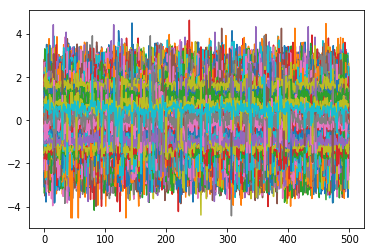

In [10]:
for i in range(13):
    for j in range(100):
        plt.plot(mu_s[:,i,j])

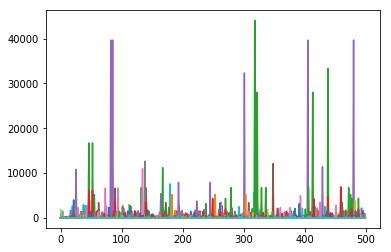

In [11]:
for i in range(13):
    for j in range(100):
        plt.plot(sigmasq_s[:,i,j])

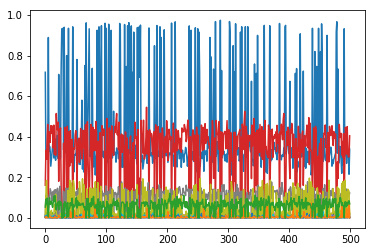

In [12]:
for i in range(13):
    plt.plot(pi_s[:,i])

In [13]:
import numpy as np
clusters = np.vstack([pi_s.mean(0)[i] * \
           stats.multivariate_normal(mu_s.mean(0)[i], np.sqrt(sigmasq_s.mean(0))[i]).pdf(y) \
           for i in range(13)]).argmax(axis=0)

(array([ 84.,   2.,   2., 113.,   1.,   0.,   1.,  32.,   7.,   0.,   1.,
          2.,  19.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 13 Patch objects>)

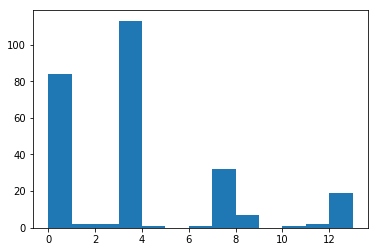

In [14]:
plt.hist(clusters, bins=range(0,14))

In [15]:
clusters

array([ 7,  7,  0,  7,  4,  0,  2,  7,  8,  6,  8,  0,  3,  3,  3,  3,  3,
        3,  7,  3,  7,  3,  3,  3,  3,  3,  7,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  7,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3, 12,  3, 12,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  0,  0,  0,  0,  0,  0,  3,  0,  0,  1,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,
        0,  0,  0,  0,  2,  3,  7,  7,  0,  0,  0,  3,  0,  0,  0, 12,  0,
        0,  0,  0,  7,  7,  7,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  7,
        7,  3,  3,  3,  7,  3,  3,  7,  3,  0,  3,  7,  3,  3,  7,  3,  3,
        7,  7,  7, 10,  0,  3,  3,  3,  7,  0,  8,  0,  7,  7,  7,  3,  3,
        0,  8,  3,  3,  3,  0,  0,  8,  0,  0,  0,  3,  8,  0,  0,  3,  3,
        3,  3,  3,  3,  3,  3,  0, 12,  3,  0,  0, 12, 12,  0,  0,  0,  0,
       12, 12, 12, 12, 12

In [16]:
PA = pd.read_csv('Power-Atlas.csv')
PA = list(PA.subnetwork)
dic_y = {}
count=0
for i in PA:
    if i not in set(dic_y.keys()):
        dic_y[i]=count
        count+=1
y_encode = [dic_y[i] for i in PA]

In [17]:
from sklearn import metrics
#metrics.adjusted_rand_score(clusters, y_encode)
#metrics.adjusted_rand_score(clusters, y_encode)
#metrics.adjusted_mutual_info_score(clusters, y_encode)
metrics.homogeneity_score(clusters, y_encode),metrics.completeness_score(clusters, y_encode),metrics.v_measure_score(clusters, y_encode)

(0.5313382406394628, 0.3209441334799374, 0.40017228187543513)

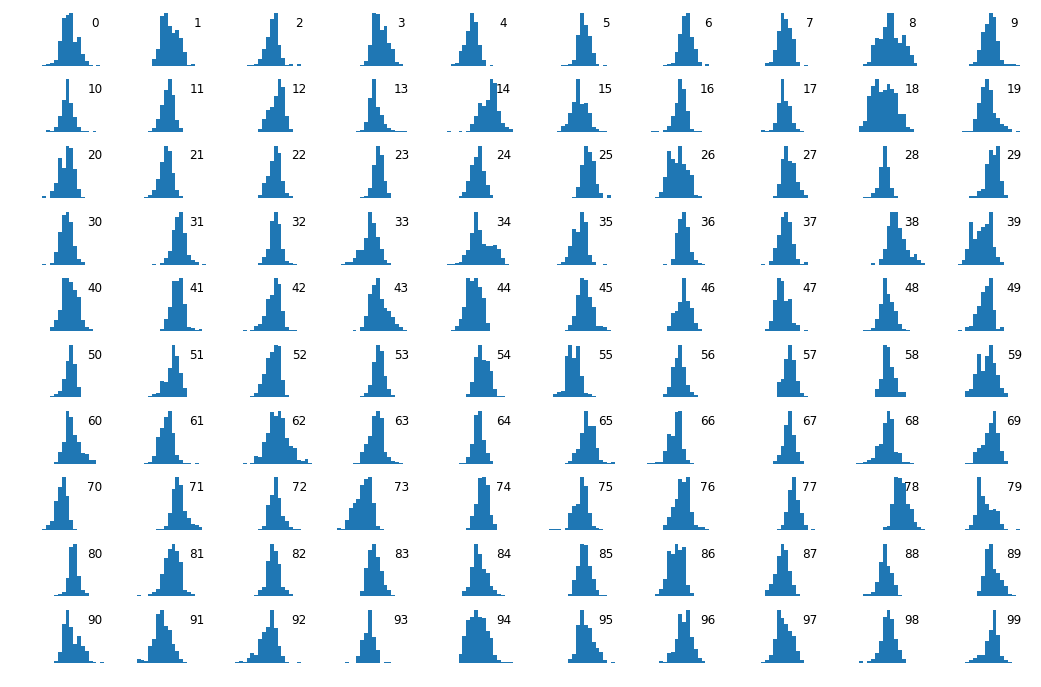

In [18]:
figsize(18, 12)
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.hist(df[:,i],bins=np.linspace(-1.0,1.0,21))
    plt.axis('off')
    plt.title(str(i), position=(0.8, 0.6))

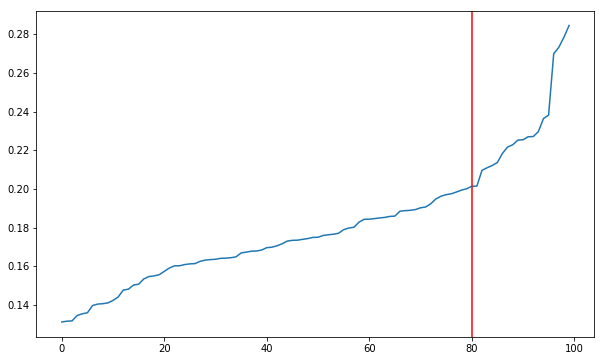

In [19]:
std_100=[]
for i in range(100):
    std_100.append(np.std(df[:,i]))
std_100 = [(i,j) for i,j in enumerate(std_100)]
std_100.sort(key=lambda x: x[1])
std_value = [i[1] for i in std_100]
figsize(10, 6)
plt.plot(std_value)
plt.axvline(x=80, color='red')

In [20]:
std_index = [i[0] for i in std_100][80:]
#std_index

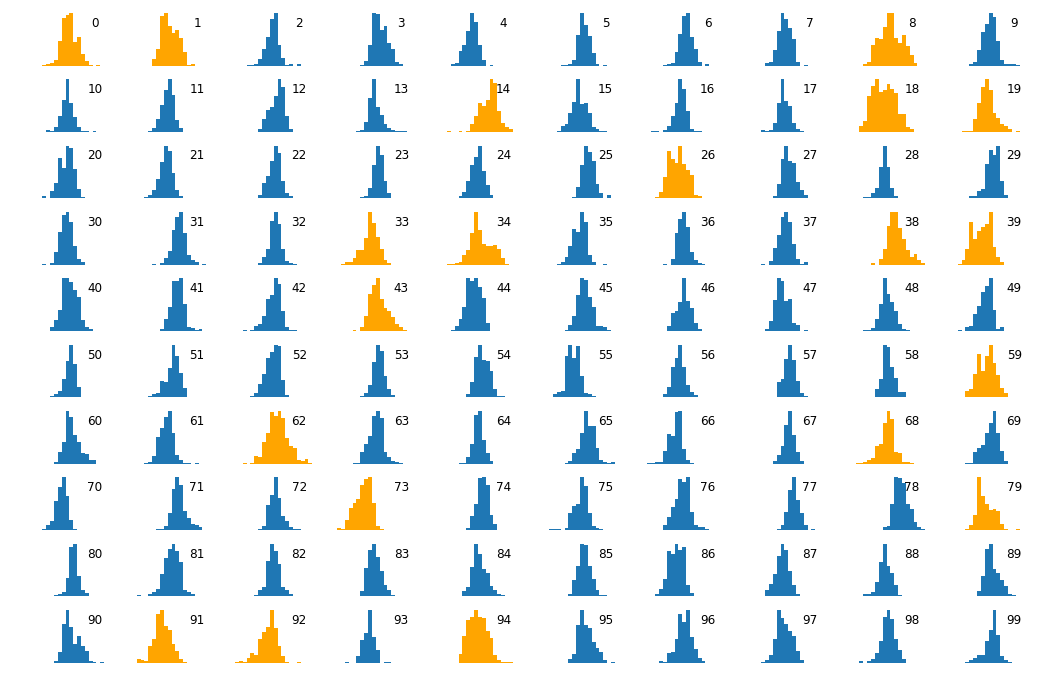

In [21]:
figsize(18, 12)
for i in range(100):
    if i in set(std_index):
        plt.subplot(10,10,i+1)
        plt.hist(df[:,i], color='orange',bins=np.linspace(-1.0,1.0,21))
        plt.axis('off')
        plt.title(str(i), position=(0.8, 0.6))
    else:
        plt.subplot(10,10,i+1)
        plt.hist(df[:,i],bins=np.linspace(-1.0,1.0,21))
        plt.axis('off')
        plt.title(str(i), position=(0.8, 0.6))


In [22]:
df[:,std_index].shape

(264, 20)

In [23]:
df = df[:,std_index]

In [24]:
k = 13  # number of clusters

d = df.shape[1]
n = df.shape[0]

pi_2 = ed.models.Dirichlet(tf.ones(k))
mu_2 = ed.models.Normal(tf.zeros(d), tf.ones(d), sample_shape=k)  # shape (3, 4) 3 gaussians, 4 variates
sigmasq_2 = ed.models.InverseGamma(tf.ones(d), tf.ones(d), sample_shape=k)
x_2 = ed.models.ParamMixture(pi, {'loc': mu_2, 'scale_diag': tf.sqrt(sigmasq_2)},
                 ed.models.MultivariateNormalDiag,
                 sample_shape=n)
z_2 = x_2.cat

In [25]:
t = 500  # number of samples

q_pi_2 = ed.models.Empirical(tf.get_variable('q_pi_2', shape=[t, k], initializer=tf.constant_initializer(1 / k)))
q_mu_2 = ed.models.Empirical(tf.get_variable('q_mu_2', shape=[t, k, d], initializer=tf.zeros_initializer()))
q_sigmasq_2 = ed.models.Empirical(tf.get_variable('q_sigmasq_2', shape=[t, k, d], initializer=tf.ones_initializer()))
q_z_2 = ed.models.Empirical(tf.get_variable('q_z_2', shape=[t, n], initializer=tf.zeros_initializer(), dtype=tf.int32)) 


In [26]:
#df = pd.DataFrame(load_iris()['data'])
y = df
# Standardize the data
y = (y - y.mean(axis=0)) / y.std(axis=0)

In [27]:
inference = ed.Gibbs({pi_2: q_pi_2, mu_2: q_mu_2, sigmasq_2: q_sigmasq_2, z_2: q_z_2}, 
                    data={x_2: y})
inference.run()

/anaconda3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 7s | Acceptance Rate: 1.000


In [28]:
mu_s_2 = q_mu_2.sample(500).eval()
sigmasq_s_2 = q_sigmasq_2.sample(5000).eval()
pi_s_2 = q_pi_2.sample(500).eval()

In [29]:
import numpy as np
clusters_2 = np.vstack([pi_s_2.mean(0)[i] * \
           stats.multivariate_normal(mu_s_2.mean(0)[i], np.sqrt(sigmasq_s_2.mean(0))[i]).pdf(y) \
           for i in range(13)]).argmax(axis=0)

(array([31., 23.,  4., 16., 48.,  9., 11., 18.,  8., 57., 15., 20.,  4.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 13 Patch objects>)

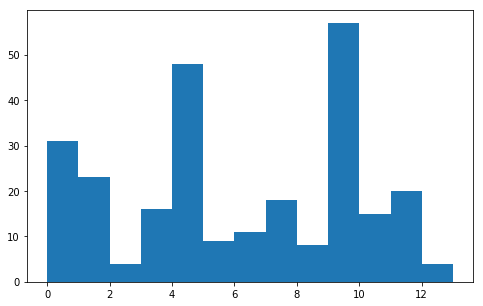

In [30]:
figsize(8, 5)
plt.hist(clusters_2, bins=range(0,14))

In [31]:
clusters_2

array([ 1,  1, 10,  6, 10, 10, 12,  1,  6, 12,  3, 10,  0,  0,  9,  0,  0,
        9,  1,  0,  1,  9,  0,  9,  0,  9,  1,  0,  9,  0,  9,  0,  0,  0,
        9, 12,  1,  9,  0,  0, 12,  9,  9,  9,  9,  9,  0, 11,  0,  0,  0,
       11,  0,  0, 11,  9, 11, 11,  7, 11,  9,  9,  9,  9,  9,  9,  9, 11,
        9,  9,  9, 11,  9,  4, 10, 10,  7,  6,  4,  9,  4,  4,  6,  6, 10,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4, 10,  4,  4,  4,  6,  4, 10,  4,  4, 10,
        4,  4,  4,  4,  9,  9,  1,  8,  4,  4,  4,  9, 10,  4,  7,  7,  7,
       10, 10,  4,  1,  1,  1,  9,  9,  9,  9, 11,  9,  9,  9,  9,  9,  1,
        1,  9,  9,  9,  1,  7,  9,  1,  9,  7,  9,  1,  7,  9,  1,  9,  9,
        1,  1,  1,  3,  3,  3, 11,  3,  1, 10,  3, 10,  8,  8,  8, 11,  3,
        7,  0, 11,  0,  3,  3,  3,  3,  3,  4,  3, 11,  3,  3,  3,  0, 11,
        0, 11, 11, 11, 11, 11,  7,  7,  0,  4,  7,  7,  7,  7,  7,  6,  7,
        5,  2,  2,  2,  5

In [32]:
PA = pd.read_csv('Power-Atlas.csv')
PA = list(PA.subnetwork)
dic_y = {}
count=0
for i in PA:
    if i not in set(dic_y.keys()):
        dic_y[i]=count
        count+=1
y_encode = [dic_y[i] for i in PA]


In [33]:
np.array(y_encode)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  0,  0,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  0,  6,  6,  6,  6,
        5,  7,  5,  0,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  0,  0,  0,  0,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  6,
       11, 11, 11, 11, 11

In [34]:
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score(clusters_2, y_encode)

0.5382514012358816

In [35]:
from sklearn import metrics
#metrics.adjusted_rand_score(clusters, y_encode)
#metrics.adjusted_rand_score(clusters, y_encode)
#metrics.adjusted_mutual_info_score(clusters, y_encode)
metrics.homogeneity_score(clusters_2, y_encode),metrics.completeness_score(clusters_2, y_encode),metrics.v_measure_score(clusters_2, y_encode)

(0.5382514012358816, 0.517414831038827, 0.5276274817027654)

# patient

In [36]:
patient = pd.read_csv('patients.csv', header=None)
df = patient.values[:,1:]
df.shape

(264, 100)

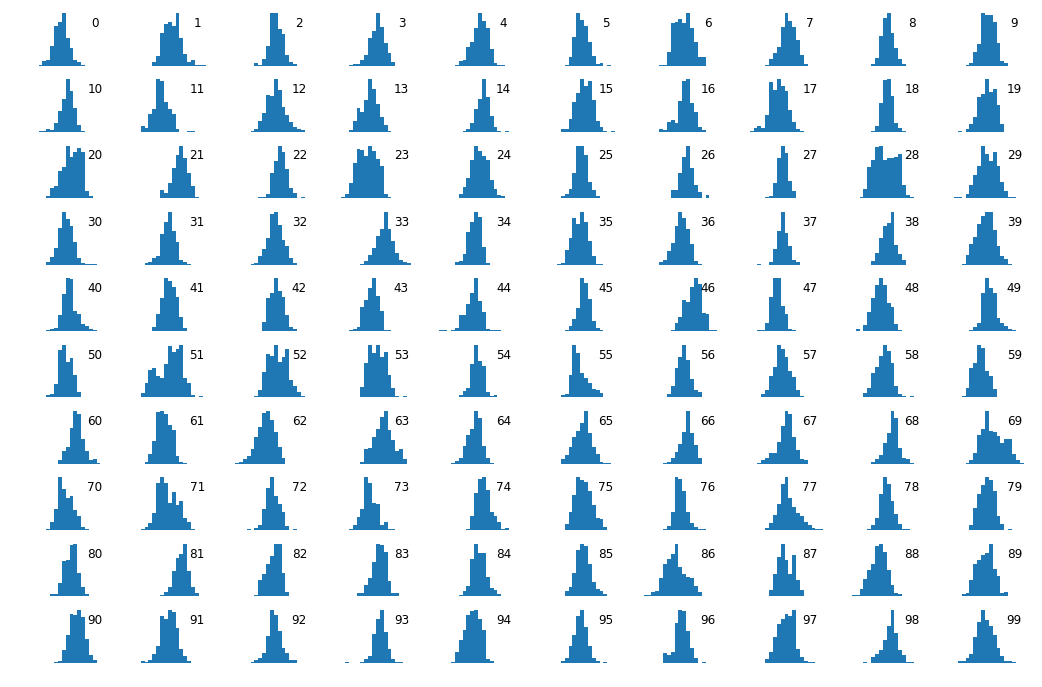

In [37]:
figsize(18, 12)
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.hist(df[:,i],bins=np.linspace(-1.0,1.0,21))
    plt.axis('off')
    plt.title(str(i), position=(0.8, 0.6))

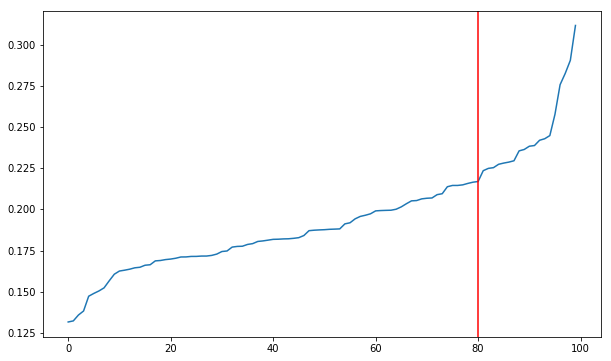

In [38]:
std_100=[]
for i in range(100):
    std_100.append(np.std(df[:,i]))
std_100 = [(i,j) for i,j in enumerate(std_100)]
std_100.sort(key=lambda x: x[1])
std_value = [i[1] for i in std_100]
figsize(10, 6)
plt.plot(std_value)
plt.axvline(x=80, color='red')

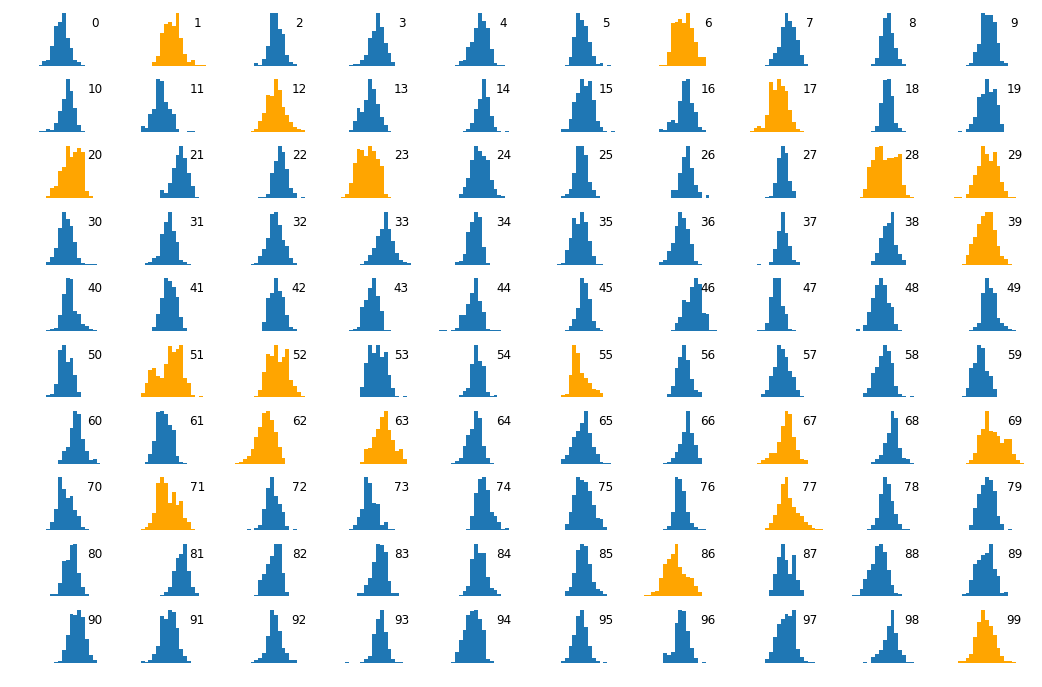

In [39]:
std_index = [i[0] for i in std_100][80:]
figsize(18, 12)
for i in range(100):
    if i in set(std_index):
        plt.subplot(10,10,i+1)
        plt.hist(df[:,i], color='orange',bins=np.linspace(-1.0,1.0,21))
        plt.axis('off')
        plt.title(str(i), position=(0.8, 0.6))
    else:
        plt.subplot(10,10,i+1)
        plt.hist(df[:,i],bins=np.linspace(-1.0,1.0,21))
        plt.axis('off')
        plt.title(str(i), position=(0.8, 0.6))

In [40]:
df = df[:,std_index]

In [41]:
k = 13  # number of clusters

d = df.shape[1]
n = df.shape[0]

pi_3 = ed.models.Dirichlet(tf.ones(k))
mu_3 = ed.models.Normal(tf.zeros(d), tf.ones(d), sample_shape=k)  # shape (3, 4) 3 gaussians, 4 variates
sigmasq_3 = ed.models.InverseGamma(tf.ones(d), tf.ones(d), sample_shape=k)
x_3 = ed.models.ParamMixture(pi_3, {'loc': mu_3, 'scale_diag': tf.sqrt(sigmasq_3)},
                 ed.models.MultivariateNormalDiag,
                 sample_shape=n)
z_3 = x_3.cat

In [42]:
t = 500  # number of samples

q_pi_3 = ed.models.Empirical(tf.get_variable('q_pi_3', shape=[t, k], initializer=tf.constant_initializer(1 / k)))
q_mu_3 = ed.models.Empirical(tf.get_variable('q_mu_3', shape=[t, k, d], initializer=tf.zeros_initializer()))
q_sigmasq_3 = ed.models.Empirical(tf.get_variable('q_sigmasq_3', shape=[t, k, d], initializer=tf.ones_initializer()))
q_z_3 = ed.models.Empirical(tf.get_variable('q_z_3', shape=[t, n], initializer=tf.zeros_initializer(), dtype=tf.int32)) 


In [57]:
q_mu_3.params.eval().shape

(500, 13, 20)

In [43]:
y = df
# Standardize the data
y = (y - y.mean(axis=0)) / y.std(axis=0)

In [44]:
inference = ed.Gibbs({pi_3: q_pi_3, mu_3: q_mu_3, sigmasq_3: q_sigmasq_3, z_3: q_z_3}, 
                    data={x_3: y})
inference.run()

/anaconda3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 8s | Acceptance Rate: 1.000


In [45]:
mu_s_3 = q_mu_3.sample(500).eval()
sigmasq_s_3 = q_sigmasq_3.sample(5000).eval()
pi_s_3 = q_pi_3.sample(500).eval()

In [46]:
import numpy as np
clusters_3 = np.vstack([pi_s_3.mean(0)[i] * \
           stats.multivariate_normal(mu_s_3.mean(0)[i], np.sqrt(sigmasq_s_3.mean(0))[i]).pdf(y) \
           for i in range(13)]).argmax(axis=0)

(array([79.,  0.,  9., 33.,  0.,  0., 25.,  0.,  4., 31., 53.,  1., 29.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 13 Patch objects>)

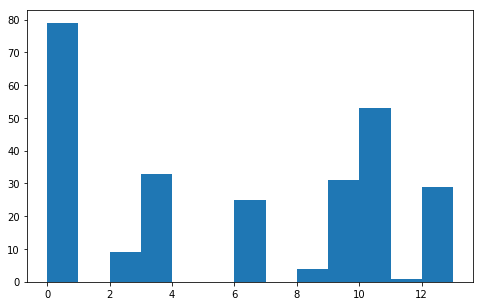

In [47]:
figsize(8, 5)
plt.hist(clusters_3, bins=range(0,14))

In [48]:
clusters_3

array([12, 12, 10, 10,  8, 12, 11, 10, 10, 12,  8, 10,  0,  0,  0,  0,  0,
        0,  0,  0,  9,  0, 12,  0,  0,  0, 10,  0, 10,  0,  0,  0,  0,  0,
        0,  0, 10,  0,  0,  0,  0,  6,  6,  6,  6,  6,  0,  0,  0,  0,  0,
        9,  0,  0,  0,  0,  6,  0,  6,  9,  6,  0, 12,  6,  0,  9,  6,  0,
        0,  9,  9,  0,  6,  0,  9,  8,  9, 10,  0,  3, 10, 10, 10, 10, 10,
        3,  3,  2,  2,  2,  2,  2,  3,  3,  2,  3, 10, 10,  9, 10,  9, 10,
       10, 10,  9,  9, 10, 10, 10, 10, 10,  9, 10,  9, 10, 10, 10, 10, 10,
       10, 10,  9, 10,  2,  0, 10, 10, 10, 10,  3, 10, 10,  2,  3,  3,  0,
       10,  0, 10, 12, 12, 12,  0,  0,  0,  0,  0,  0,  0, 12, 12,  0, 12,
       12,  0, 12,  0, 12,  0,  0, 12,  0,  0, 12, 12,  3,  0, 12,  0,  0,
        0, 12,  0,  3,  3,  3,  3,  0, 12, 10, 10, 10, 12, 10, 12,  3,  3,
        3,  3,  3,  3,  3,  9,  3,  3,  9,  3,  3,  3,  3,  3,  9,  0,  3,
        3,  3,  9,  0,  0,  9,  9,  9,  0,  9,  9,  9,  9,  9,  9,  9,  2,
        6,  6,  6,  6,  6

In [49]:
metrics.homogeneity_score(clusters_3, y_encode),metrics.completeness_score(clusters_3, y_encode),metrics.v_measure_score(clusters_3, y_encode)

(0.5006817497178279, 0.3898259784435567, 0.4383538666768593)

In [60]:
metrics.homogeneity_score(clusters_3, clusters_2),metrics.completeness_score(clusters_3, clusters_2),metrics.v_measure_score(clusters_3, clusters_2)

(0.42730392887597857, 0.34609250825336, 0.3824343672441072)